In [82]:
import pandas as pd
import numpy as np

In [414]:
# import data
# indicators

fpath = 'data_raw/SDG-DEA_indicators_V5_20200708.xlsx'

# original indicators
sdg_in = pd.read_excel(fpath,
                       sheet_name='SDG-DEA FINAL',
                       header=4,
                       index_col=0,
                       usecols='B,T:DQ',
                       skiprows=[5]
                       )

# transformed indicators
sdg_in_trans = pd.read_excel(fpath,
                       sheet_name='SDG-DEA FINAL transformed',
                       header=5,
                       index_col=0,
                       usecols='B,T:DQ',
                       skiprows=[6]
                       )        

# indicator direction and sdg 
dir_sdg_in = pd.read_excel(fpath,
                           sheet_name='SDG-DEA FINAL',
                           usecols='T:DQ',
                           nrows=3,
                           skiprows=[0,1,4],
                           header=None
                           )

# economic indicators
sdg_econ_in =  pd.read_excel(fpath,
                             sheet_name='SDG-DEA Economic',
                             usecols='B,BM:BR',
                             skiprows=[0,1,2],
                             header=2,
                             index_col=0
                             )

# mapping of econonmic indicators to sdgs
sdg_econ_map_in = pd.read_excel(fpath,
                             sheet_name='SDG-DEA Economic',
                             usecols='BN:BR',
                             skiprows=[0,1,2,4],
                             nrows=2,
                             header=None
                             )

In [415]:
# mapping sdgs to economic expenses
sdg_map = sdg_econ_map_in.copy()
sdg_map_d = {}

for ii in sdg_map.columns:
    sdgv = sdg_map.loc[0,ii]
    if (type(sdgv) == int) & (sdgv not in sdg_map_d): # if it's an integer and not mapped yet, map it
        sdg_map_d[sdgv] = sdg_map.loc[1,ii]

    elif type(sdgv) == str: # if it's not an integer, split it
        split1 = sdgv.split(',')

        if len(split1) > 1: # if multiple values indicate a list of numbers as strings
            sdgd2 = {int(vv):sdg_map.loc[1,ii] for vv in split1 if int(vv) not in sdg_map_d} # make a second dict with all new numbers and add them
            sdg_map_d.update(sdgd2)
    else:
        print('something unexpected happened')

for ii in range(1,18): # map the remaining sdgs to the final economic category
    if ii not in sdg_map_d:
        sdg_map_d[ii] = sdg_map.iloc[1,-1]

In [416]:
# filling economic data
sdg_econ = sdg_econ_in.copy()

# fix column names
sdg_econ.columns = [c.split('.')[0] for c in sdg_econ.columns] 

# fill missing and zero values with income group averages
sdg_econ.replace(0, np.nan, inplace=True)
sdg_econ.fillna(sdg_econ.groupby(sdg_econ.columns[0])[sdg_econ.columns[1:]].transform('mean'), inplace=True)

In [417]:
# fill missing indicator data with income category means
inds = sdg_in.copy()
inds_t = sdg_in_trans.copy()
inc_cat = sdg_econ.iloc[:,0].unique() # income categories

# fill nans with means of income categories
for ii in inc_cat:
    idx = sdg_econ[sdg_econ.iloc[:,0] == ii].index
    inds.loc[idx,:] = inds.loc[idx,:].fillna(inds.loc[idx,:].mean())
    inds_t.loc[idx,:] = inds_t.loc[idx,:].fillna(inds_t.loc[idx,:].mean())

inds = inds[inds.index.notnull()] # remove nan rows

# get transformed indicators, harmonise column names between inds and inds_t
inds_t = inds_t[inds_t.index.notnull()]
it_col = inds_t.columns
trans_inds = [True if ss.split('.')[0][-4:] == '_inv' else False for ss in it_col] # indicators which were transformed
inds_t.columns = inds.columns

In [418]:
# get direction and sdg data
dir_sdg = dir_sdg_in.copy()
dir_sdg.index = ['direction','sdg','ind_name']
dir_sdg = dir_sdg.fillna(method='ffill', axis=1)
dir_sdg.columns = inds.columns

ind_name_d = {k:dir_sdg.loc['ind_name',k] for k in dir_sdg.columns}

# remove SDG from string and convert to int (string format varies slightly)
dir_sdg.loc['sdg',:] = dir_sdg.loc['sdg',:].str.replace('SDG','')
dir_sdg.loc['sdg',:] = dir_sdg.loc['sdg',:].str.replace(' ','')
dir_sdg.loc['sdg',:] = dir_sdg.loc['sdg',:].astype(int)

In [419]:
# dataframe for correlation results, sdg, and transformation true/false
corr_res = pd.DataFrame(columns=['sdg', 'corr', 'corr_t', 'trans'], index=inds.columns)
corr_res['sdg'] = dir_sdg.loc['sdg',:]
corr_res['trans'] = trans_inds

# calculate correlation between indicators and associated economic expenses for original and transformed data
for s in dir_sdg.loc['sdg',:].unique():
    corrs = inds[dir_sdg.columns[dir_sdg.loc['sdg'] == s]].corrwith(sdg_econ[sdg_map_d[s]])
    corrs_t = inds_t[dir_sdg.columns[dir_sdg.loc['sdg'] == s]].corrwith(sdg_econ[sdg_map_d[s]])
    corr_res.loc[corrs.index,'corr'] = corrs.values
    corr_res.loc[corrs_t.index,'corr_t'] = corrs_t.values


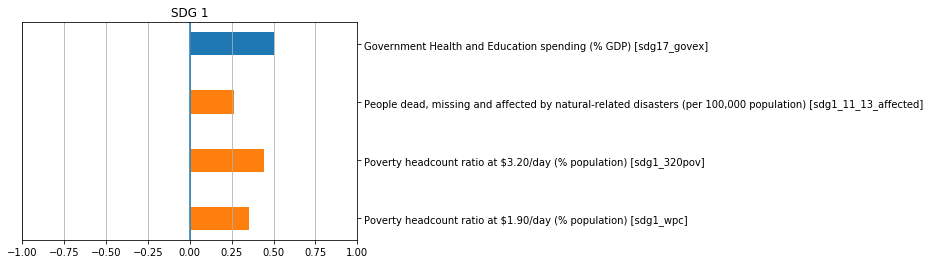

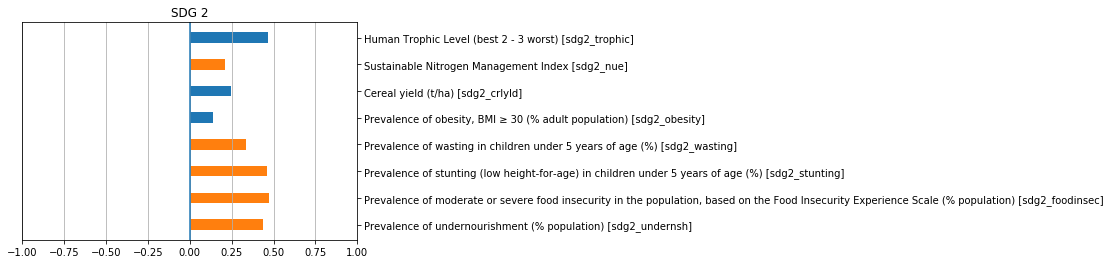

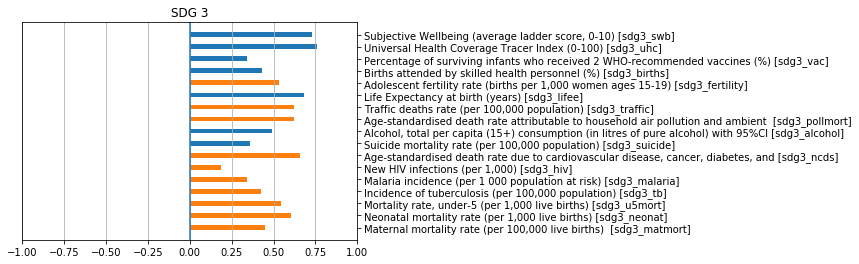

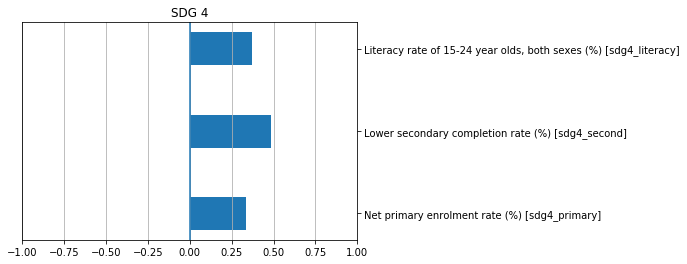

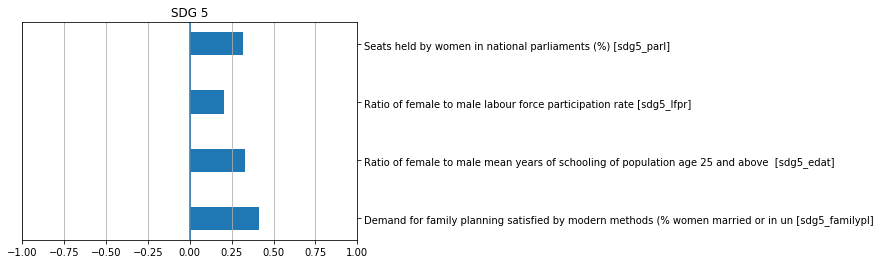

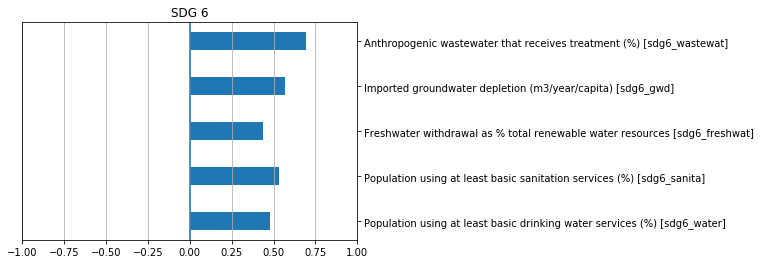

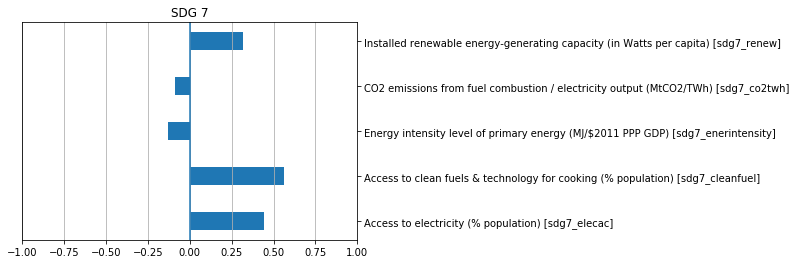

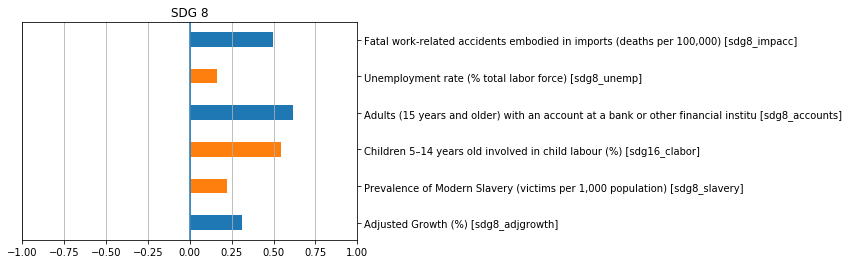

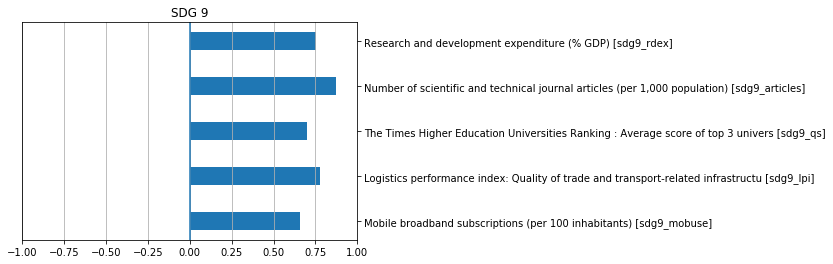

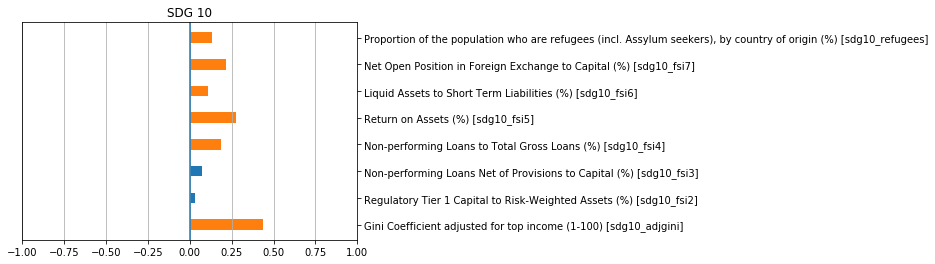

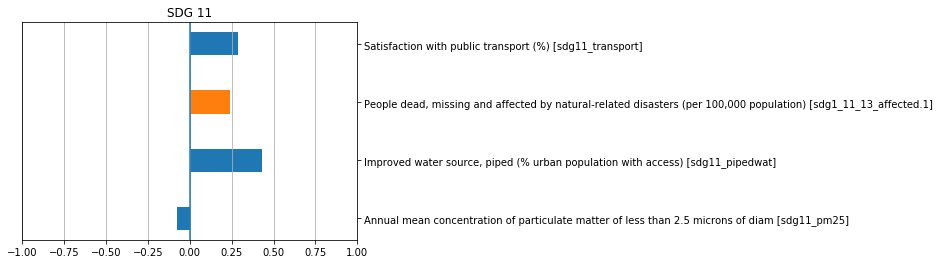

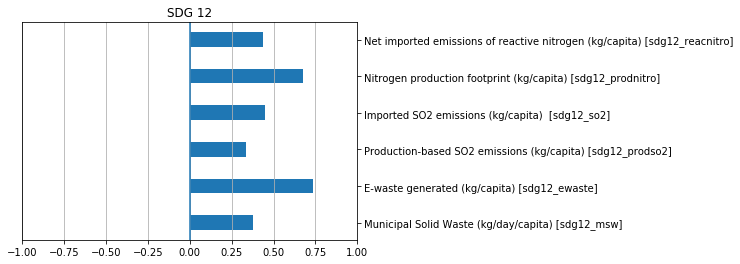

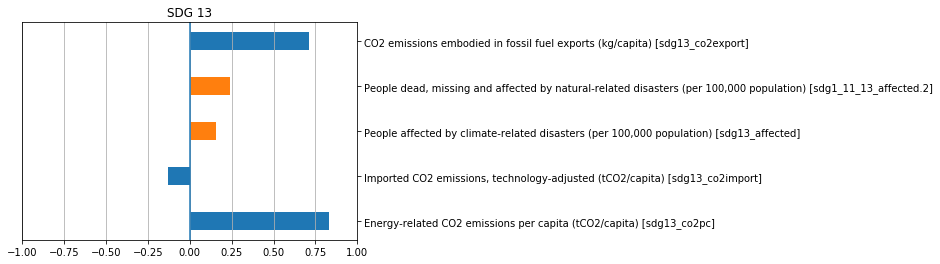

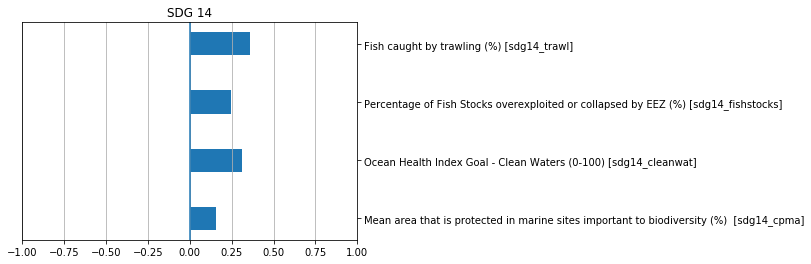

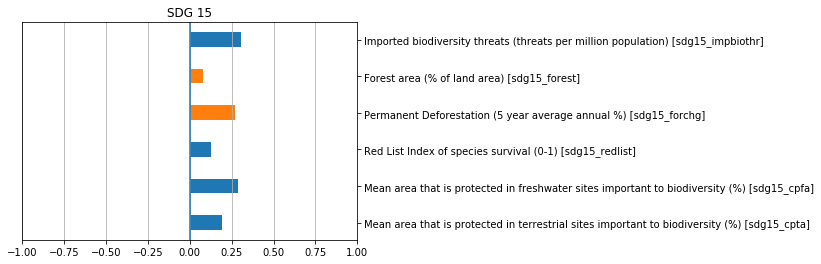

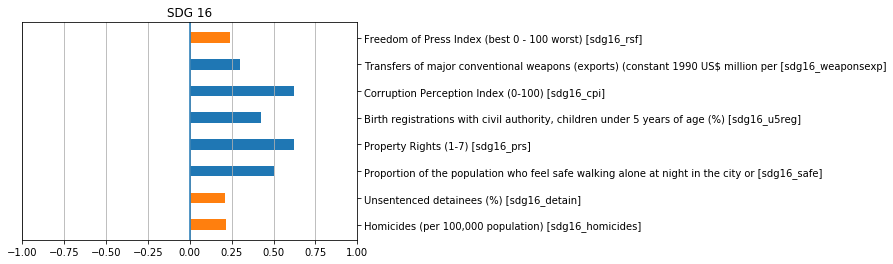

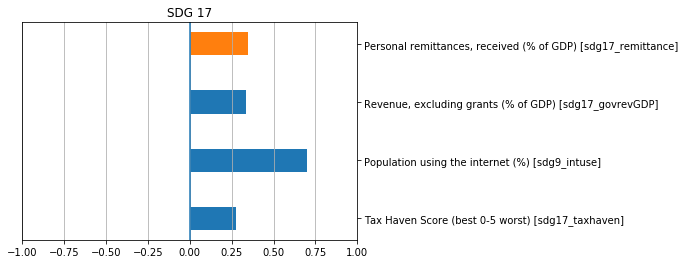

In [422]:
import matplotlib.pyplot as plt

s = 2

for s in range(1,18):
    plt.figure()
    sdg_slice = corr_res[corr_res['sdg']==s]
    pos = np.arange(sdg_slice.shape[0])

    pos_o = [ii for ii in pos if sdg_slice['trans'][ii] == False]
    pos_t = [ii for ii in pos if sdg_slice['trans'][ii] == True]

    ax2 = plt.subplot(111)
    plt.barh(pos_o, sdg_slice['corr_t'][sdg_slice['trans']==False], height=0.4, label='original')
    plt.barh(pos_t, sdg_slice['corr_t'][sdg_slice['trans']==True], height=0.4, label='transformed')
    plt.axvline()
    plt.title('SDG {0}'.format(s))
    plt.grid(axis='x')
    plt.yticks(pos, ['{0} [{1}]'.format(ind_name_d[ii],ii) for ii in sdg_slice.index])
    # plt.legend()

    ax2.set_xlim(-1,1)
    ax2.yaxis.tick_right()

    # plt.savefig('figures/sdg{0}_corr.png'.format(s), dpi=600, bbox_inches='tight')



In [3]:
# # name first column and fill missing data
# inds = sdg_in.copy()
# inds.columns = ['gdppc',*inds.columns[1:]]
# inds.fillna(inds.mean(axis=0), inplace=True)

In [4]:
# # convert indicators to "output" direction (i.e. should be more positive with higher GDPPC)
# dir_sdg = dir_sdg_in.loc[0,:].copy()
# dir_sdg = pd.Series([1]).append(dir_sdg)
# dir_sdg.index = inds.columns
# inds_allout = inds.mul(dir_sdg, axis=1)

In [12]:
# # calculate correlation of indicators with gdp per capita
# pearson_corr = inds_allout.corr().loc['gdppc',:] 
# psn_neg_sorted = pearson_corr[pearson_corr < 0].sort_values() # indicators with negative correlation, sorted

In [18]:
# import seaborn as sns
# # import matplotlib.pyplot as plt

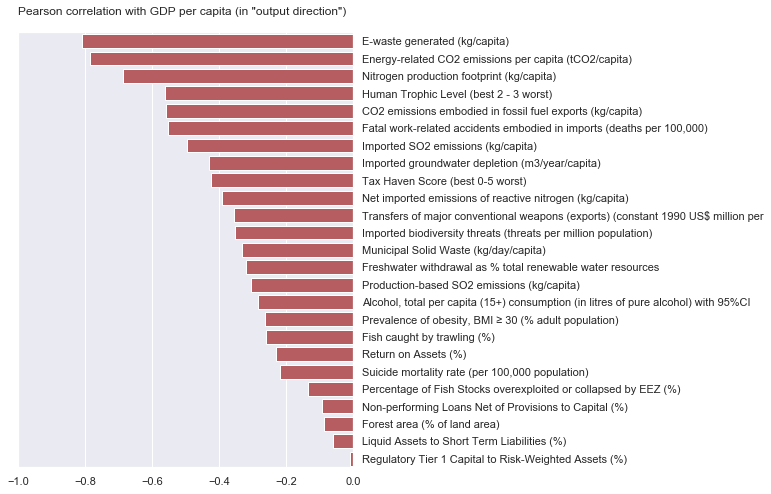

In [24]:
# # plot bar chart of indicators with negative correlations
# sns.set(rc={'figure.figsize':(6,8)})
# b = sns.barplot(psn_neg_sorted.values, psn_neg_sorted.index, orient='h', color='r')
# b.set_xlim(-1,0)
# b.yaxis.set_ticks_position('right')
# b.yaxis.set_ticks_position('none')
# plt.xlabel('abcd', ha='left')

# b.set(xlabel='Pearson correlation with GDP per capita (in "output direction")')
# b.xaxis.set_label_position('top')
# b.xaxis.labelpad = 5

# b.xaxis.set_label_coords(0, 1.04)

# b.get_figure().savefig('isotonicity_exclude.png', dpi=600, bbox_inches='tight')


In [58]:
# # forward fill sdg data NaNs
# dir_sdg = dir_sdg_in.copy()
# dir_sdg.index = ['direction','sdg']
# dir_sdg = dir_sdg.fillna(method='ffill', axis=1)

# # combine correlation with sdg, also remove space between sdg and number while we're at it
# psn_sdg = pearson_corr[1:].to_frame()
# psn_sdg['sdg'] = [''.join(ii.split(' ')) for ii in dir_sdg.loc['sdg',:].values]

# # calculate how many indicators need to be removed/kept for each SDG due to isotonicity issues
# iso_rem = pd.DataFrame(columns=['keep','remove'], index=range(1,psn_sdg['sdg'].unique().shape[0]+1))
# for ii,s in enumerate(psn_sdg['sdg'].unique()):
#     iso_rem.loc[ii+1,'remove'] = psn_sdg[(psn_sdg['sdg']==s) & (psn_sdg['gdppc']<0)].shape[0]
#     iso_rem.loc[ii+1,'keep'] = psn_sdg[(psn_sdg['sdg']==s) & (psn_sdg['gdppc']>=0)].shape[0]

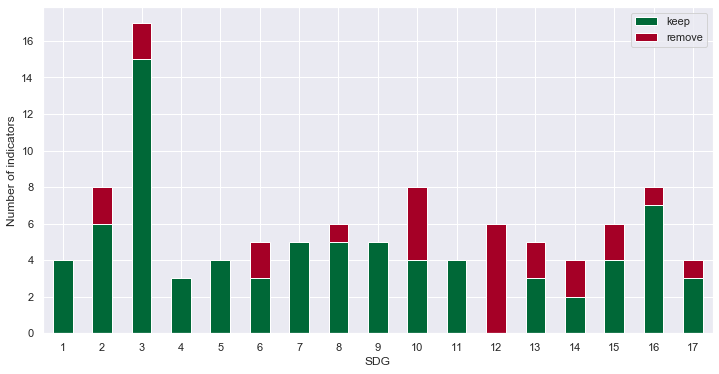

In [61]:
# # stacked bar chart of how many indicators get kept/removed for each sdg
# import seaborn as sns
# sns.set()
# ax = iso_rem.plot(kind='bar', stacked=True, figsize=(12,6), colormap='RdYlGn_r')
# ax.set_ylabel('Number of indicators')
# ax.set_xlabel('SDG')
# ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
# ax.get_figure().savefig('indicators_keep_remove.png', dpi=600, bbox_inches='tight')

